# Human Short Promoter Classification with Genomic Pretraining and Fine Tuning

This notebook builds on the previous one by adding a fine tuning step to the genomic language model before training the classification model on the short promoter dataset. The classification model produced at the end of this notebook is the result of running the full three stage ULMFiT Process:
  1. Train a genomic language model on a large general corpus (the human genome)
  2. Fine tune the language model on the classification corpus (the promoter dataset)
  3. Train the classification model
  
The fine tuning step was absent from the E. coli notebooks because the classification corpus was small and trying to fine tune overfit the language model and reduced classification performance. The human short promoters dataset is large enough to use fine tuning. Fine tuning the language model results in improved performance  in the classification task.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

# LM Fine Tune

Here we create a language model corpus from our classification dataset. This basically concatenates all our promoter sequences into a single long string of text. The language model is trained on the concatenated promoter corpus. We need to make sure to create our dataloader with the correct vocabulary.

In [5]:
classification_df = pd.read_csv(path/'human_promoters_short.csv')

In [6]:
classification_df.head()

,Sequence,Promoter,set
0,CTGTGAGTGCATACACCCTAGGTTGGGTAGGTGACCAGAGGACCTT...,1,train
1,GGGTCCGGTCGGGCGCCGCGGGGCCGTAGTTTTCGGGTCGGCGGGC...,1,train
2,GGAGTTCACTTAAGCTCTCCACCTACCTTGCTATATCTCTCCTCCC...,1,train
3,GTGAGGCGCGCGCTTGCCTGGCTAGGGTCCCTGTGAAGGAATGGGA...,1,train
4,CCCTAGGTTCTGCTCCCGACAGGCCGTCGCGGGACCGGAGCCCTCG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'human_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=8, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=800, tokenizer=tok, 
                              chunksize=30000, text_cols='Sequence', label_cols='Promoter', vocab=model_vocab)

In [13]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [14]:
learn = get_model_LM(data, drop_mult, config)

We initialize the model by loading the weights from the human genome language model

In [15]:
learn = learn.to_fp16(dynamic=True);
learn.load('human_3m1s2');

In [16]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


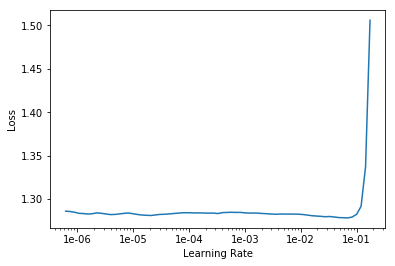

In [18]:
learn.lr_find()
learn.recorder.plot()

# Training

This trained surprisingly well. As I later discovered, many sequences in the negative dataset had large regions of homology to other sequences in the dataset, allowing the model to learn a simple set of features that achieves high accuracy on the language modeling task. This is discussed further in the data quality section

In [19]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.260708,1.245436,0.429618,01:37
1,1.216936,1.193480,0.462778,01:37
2,1.150216,1.123488,0.504377,01:38
3,1.067393,1.042100,0.546083,01:38
4,0.976314,0.954547,0.588781,01:38
5,0.897699,0.886762,0.620013,01:38
6,0.831771,0.831328,0.644731,01:37
7,0.785748,0.797488,0.659470,01:38
8,0.761022,0.782243,0.665579,01:38
9,0.747926,0.779669,0.666465,01:38


In [20]:
learn.save('human_LM_short_3m1s')
learn.save_encoder('human_LM_short_3m1s_enc')

# Classification

Now we train our standard classification model using the usual procedure. Only now we initialize with the fine tuned language model weights.

In [5]:
classification_df = pd.read_csv(path/'human_promoters_short.csv')

In [6]:
classification_df.head()

,Sequence,Promoter,set
0,CTGTGAGTGCATACACCCTAGGTTGGGTAGGTGACCAGAGGACCTT...,1,train
1,GGGTCCGGTCGGGCGCCGCGGGGCCGTAGTTTTCGGGTCGGCGGGC...,1,train
2,GGAGTTCACTTAAGCTCTCCACCTACCTTGCTATATCTCTCCTCCC...,1,train
3,GTGAGGCGCGCGCTTGCCTGGCTAGGGTCCCTGTGAAGGAATGGGA...,1,train
4,CCCTAGGTTCTGCTCCCGACAGGCCGTCGCGGGACCGGAGCCCTCG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'human_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=8, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400, chunksize=50000)

In the config I reduced the `drop_mult` value slightly from 0.6 to 0.5. One thing I consistently see with these models is that the better your language model is, the less regularization you need in your classification model.

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(65, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(65, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, a

In [15]:
learn.load_encoder('human_LM_short_3m1s_enc')
learn = learn.to_fp16(dynamic=True);
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


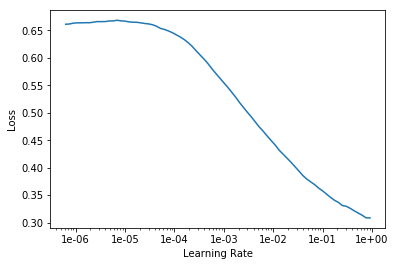

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.137800,0.034762,0.989947,00:49
1,0.113175,0.034767,0.991706,00:50
2,0.106393,0.030328,0.992209,00:50


In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.082844,0.020120,0.995728,01:00
1,0.061253,0.017781,0.995728,01:00
2,0.048534,0.014405,0.997235,01:00


In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.041115,0.013721,0.996230,01:31
1,0.037352,0.012390,0.997487,01:32


In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.034784,0.012896,0.997738,01:53
1,0.025418,0.010950,0.997989,01:52


In [21]:
learn.save('human_short_human_pretrain_finetune_3m1s')

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=400, chunksize=50000)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.995729537366548
False Positives: 0.00298932384341637
False Negatives: 0.001281138790035587
Recall: 0.9969686763219939
Precision: 0.9929553840992955
Specificity: 0.9948224852071006
MCC: 0.9912603711351132
